(Bayesian Missing Data Imputation)=
# Bayesian Missing Data Imputation

:::{post} January, 2023
:tags: missing data, multiple imputation, 
:category: advanced
:author: Nathaniel Forde
:::

## Introduction

In [832]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import scipy.optimize
import random

## Bayesian Imputation and Degrees of Missing-ness

FILL IN INTRO TEXT

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Missing Data: Employee Satisfaction Surveys

We'll follow the presentation of Craig Enders' *Applied Missing Data Analysis* and work with employee satisifaction data set. 


In [292]:
df_employee = pd.read_csv('../data/employee.csv')
df_employee

,employee,team,turnover,male,empower,lmx,worksat,climate,cohesion
0,1,1,0.0,1,32.0,11.0,3.0,18.0,3.5
1,2,1,1.0,1,NaN,13.0,4.0,18.0,3.5
2,3,1,1.0,1,30.0,9.0,4.0,18.0,3.5
3,4,1,1.0,1,29.0,8.0,3.0,18.0,3.5
4,5,1,1.0,0,26.0,7.0,4.0,18.0,3.5
...,...,...,...,...,...,...,...,...,...
625,626,105,1.0,0,28.0,5.0,4.0,21.0,5.0
626,627,105,1.0,0,17.0,5.0,3.0,21.0,5.0
627,628,105,1.0,1,28.0,10.0,4.0,21.0,5.0
628,629,105,0.0,0,NaN,9.0,4.0,21.0,5.0


In [741]:
df_employee[['worksat', 'empower', 'lmx']].isna().sum() / len(df_employee)

worksat    0.047619
empower    0.161905
lmx        0.041270
dtype: float64

Text(0.5, 1.0, 'Employee Satisfaction Survey Results')

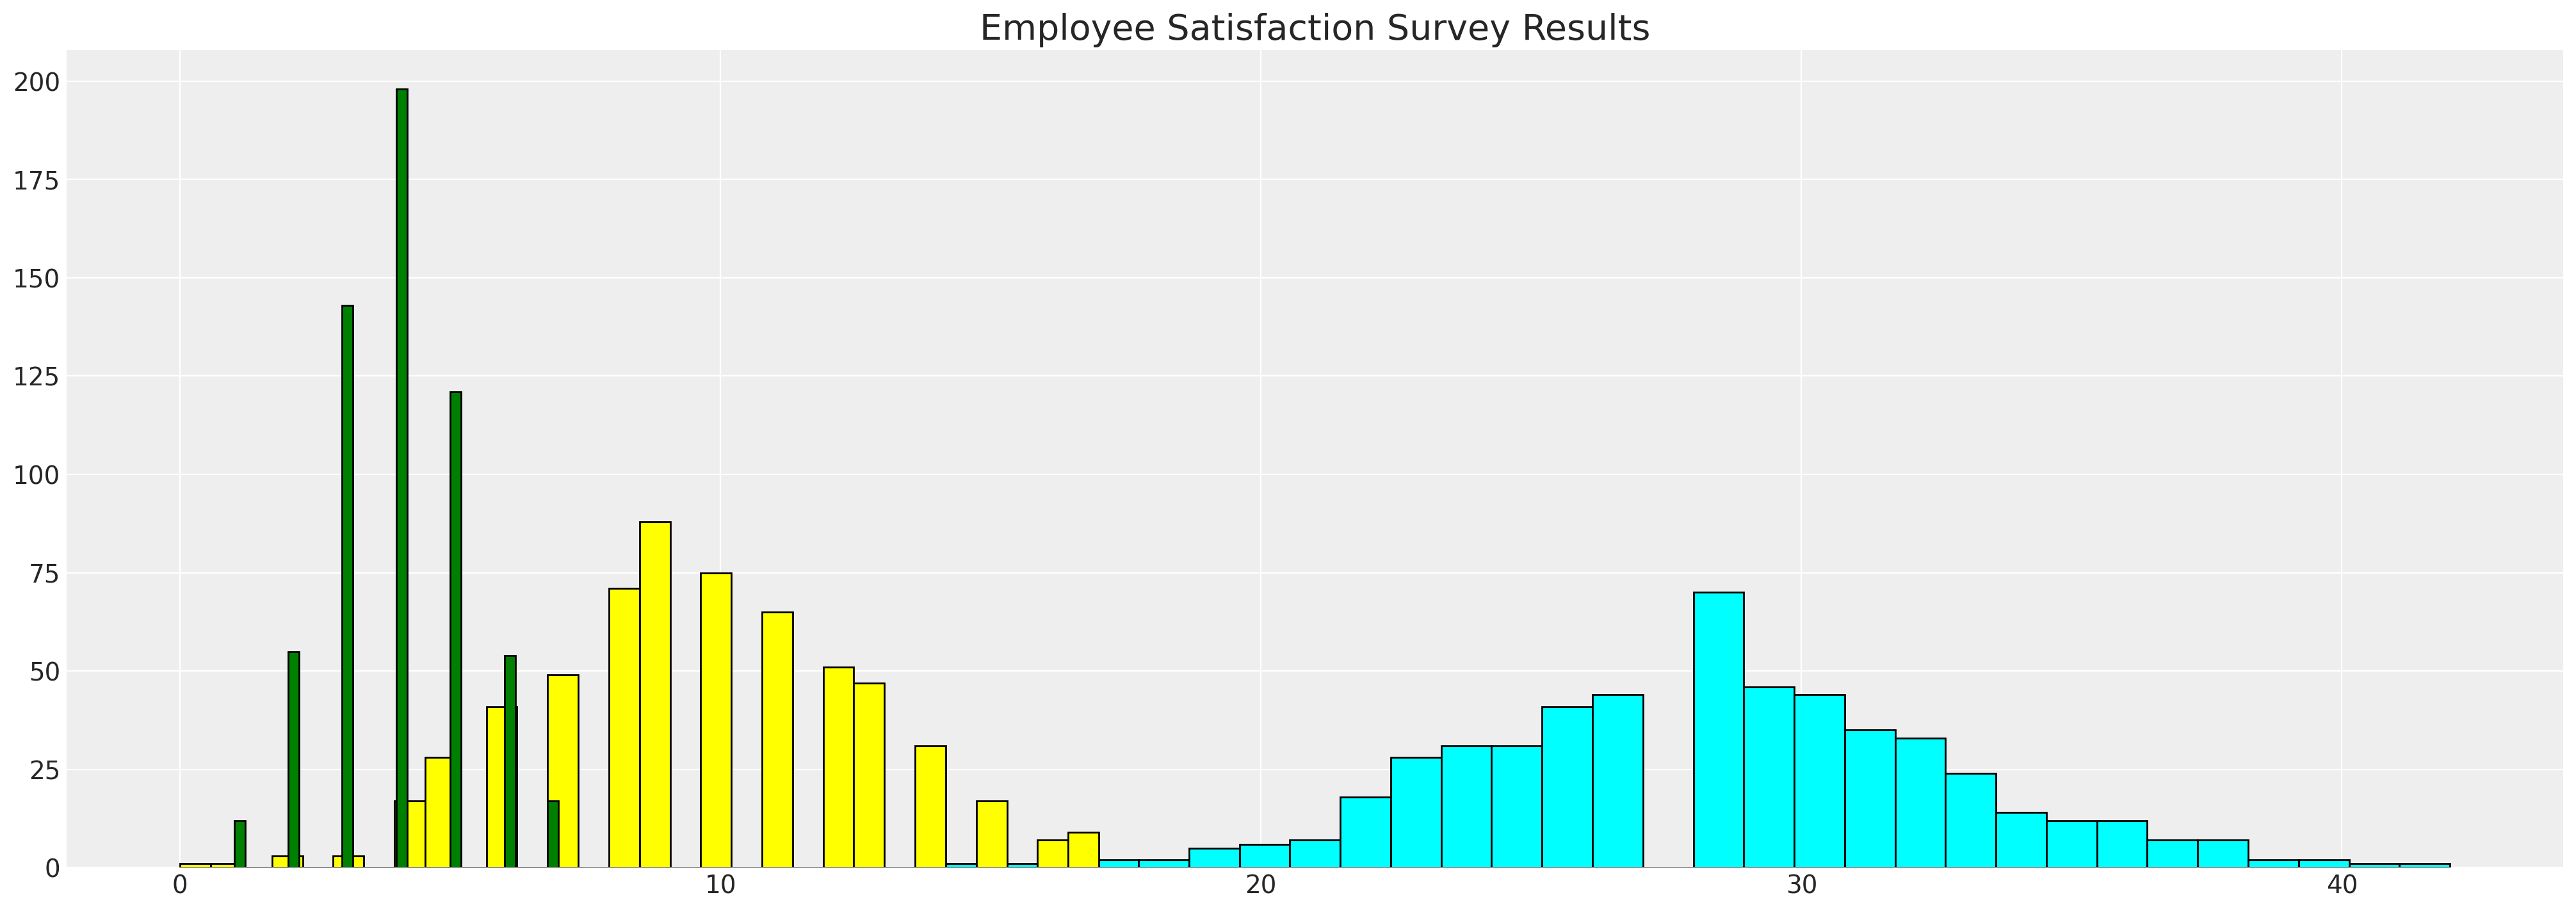

In [828]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(df_employee['empower'], bins=30, ec='black', color='cyan', label='Empowerment')
ax.hist(df_employee['lmx'], bins=30, ec='black', color='yellow', label='LMX')
ax.hist(df_employee['worksat'], bins=30, ec='black', color='green', label='Work Satisfaction')
ax.set_title("Employee Satisfaction Survey Results", fontsize=20)

## FIML: Full Information Maximum Likelihood 

This method of handling missing data is **not** an imputation method. It uses maximum likelihood estimation to estimate the parameters of the multivariate normal distribution that could be best said to generate our observed data. It's a little trickier than straight forward MLE approaches in that it respects the fact that we have missing data in our original data set. 

The procedure works by partitioning the data into their patterns of "missing-ness" and treating each partition as contributing to the ultimate log-likelihood term that we want to maximise. We combine their contributions to estimate a fit for the multivariate normal distribution.  

In [731]:

data = df_employee[['worksat', 'empower', 'lmx']]

def split_data_by_missing_pattern(data):
    ## We want to extract our the pattern of missing-ness in our dataset
    ## and save each sub-set of our data in a structure that can be used to feed into a log-likelihood function
    grouped_patterns = []
    patterns = data.notnull().drop_duplicates().values
    # A pattern is whether the values in each column e.g. [True, True, True] or [True, True, False]
    observed = data.notnull()
    for p in range(len(patterns)):
        temp = observed[(observed['worksat'] == patterns[p][0]) & (observed['empower'] == patterns[p][1]) & (observed['lmx'] == patterns[p][2])]
        grouped_patterns.append([patterns[p], temp.index, data.iloc[temp.index].dropna(axis=1)])

    return grouped_patterns

def reconstitute_params(params_vector, n_vars):
    ## Convenience numpy function to construct mirrored COV matrix
    ## From flattened params_vector
    mus = params_vector[0:n_vars]
    cov_flat = params_vector[n_vars:]
    indices = np.tril_indices(n_vars)
    cov = np.empty((n_vars, n_vars))
    for i, j, c in zip(indices[0], indices[1], cov_flat):
         cov[i, j] = c
         cov[j, i] = c
    cov = cov + 1e-25
    return mus, cov

def optimise_ll(flat_params, n_vars, grouped_patterns):
    mus, cov = reconstitute_params(flat_params, n_vars)
    ## Check if COV is positive definite
    if (np.linalg.eigvalsh(cov) < 0).any():
        return 1e100
    objval = 0.0
    for obs_pattern, _, obs_data in grouped_patterns:
        ## This is the key (tricky) step because we're selecting the variables which pattern
        ## the full information set within each pattern of "missing-ness"
        ## e.g. when the observed pattern is [True, True, False] we want the first two variables
        ## of the mus vector and we want only the covariance relations between the relevant variables from the cov
        ## in the iteration.
        obs_mus = mus[obs_pattern]
        obs_cov = cov[obs_pattern][:, obs_pattern]
        ll = np.sum(multivariate_normal(obs_mus, obs_cov).logpdf(obs_data))
        objval = ll + objval
    return -objval

def estimate(data):
    n_vars = data.shape[1]
    ## Initialise
    mus0 = np.zeros(n_vars)
    cov0 = np.eye(n_vars)
    ## Flatten params for optimiser
    params0 = np.append(mus0, cov0[np.tril_indices(n_vars)])
    ## Process Data
    grouped_patterns = split_data_by_missing_pattern(data)
    ## Run the Optimiser. 
    try:
        result = scipy.optimize.minimize(
            optimise_ll, params0, args=(n_vars, grouped_patterns), method='Powell')
    except Exception as e:
        raise e
    mean, cov = reconstitute_params(result.x, n_vars)
    return mean, cov


fiml_mus, fiml_cov = estimate(data)


print("Full information Maximum Likelihood Estimate Mu:")
display(pd.DataFrame(fiml_mus, index=data.columns).T)
print("Full information Maximum Likelihood Estimate COV:") 
pd.DataFrame(fiml_cov, columns=data.columns,index=data.columns)


Full information Maximum Likelihood Estimate Mu:


,worksat,empower,lmx
0,3.983351,28.595211,9.624485


Full information Maximum Likelihood Estimate COV:


,worksat,empower,lmx
worksat,1.568676,1.599817,1.547433
empower,1.599817,19.138522,5.428954
lmx,1.547433,5.428954,8.934030


### Sampling from the Implied Distribution

In [726]:
mle_fit = multivariate_normal(fiml_mus, fiml_cov)
mle_sample = mle_fit.rvs(10000)
mle_sample = pd.DataFrame(mle_sample, columns = ['worksat', 'empower', 'lmx'])
mle_sample

,worksat,empower,lmx
0,5.061543,27.487430,10.996024
1,2.914115,26.105437,5.100912
2,4.089605,21.899616,10.273928
3,4.872349,27.791575,11.105043
4,4.672187,28.723287,15.150135
...,...,...,...
9995,5.778542,35.395322,10.527795
9996,3.617286,35.615304,14.353624
9997,4.779451,33.047298,14.532048
9998,2.397379,24.175939,7.566302


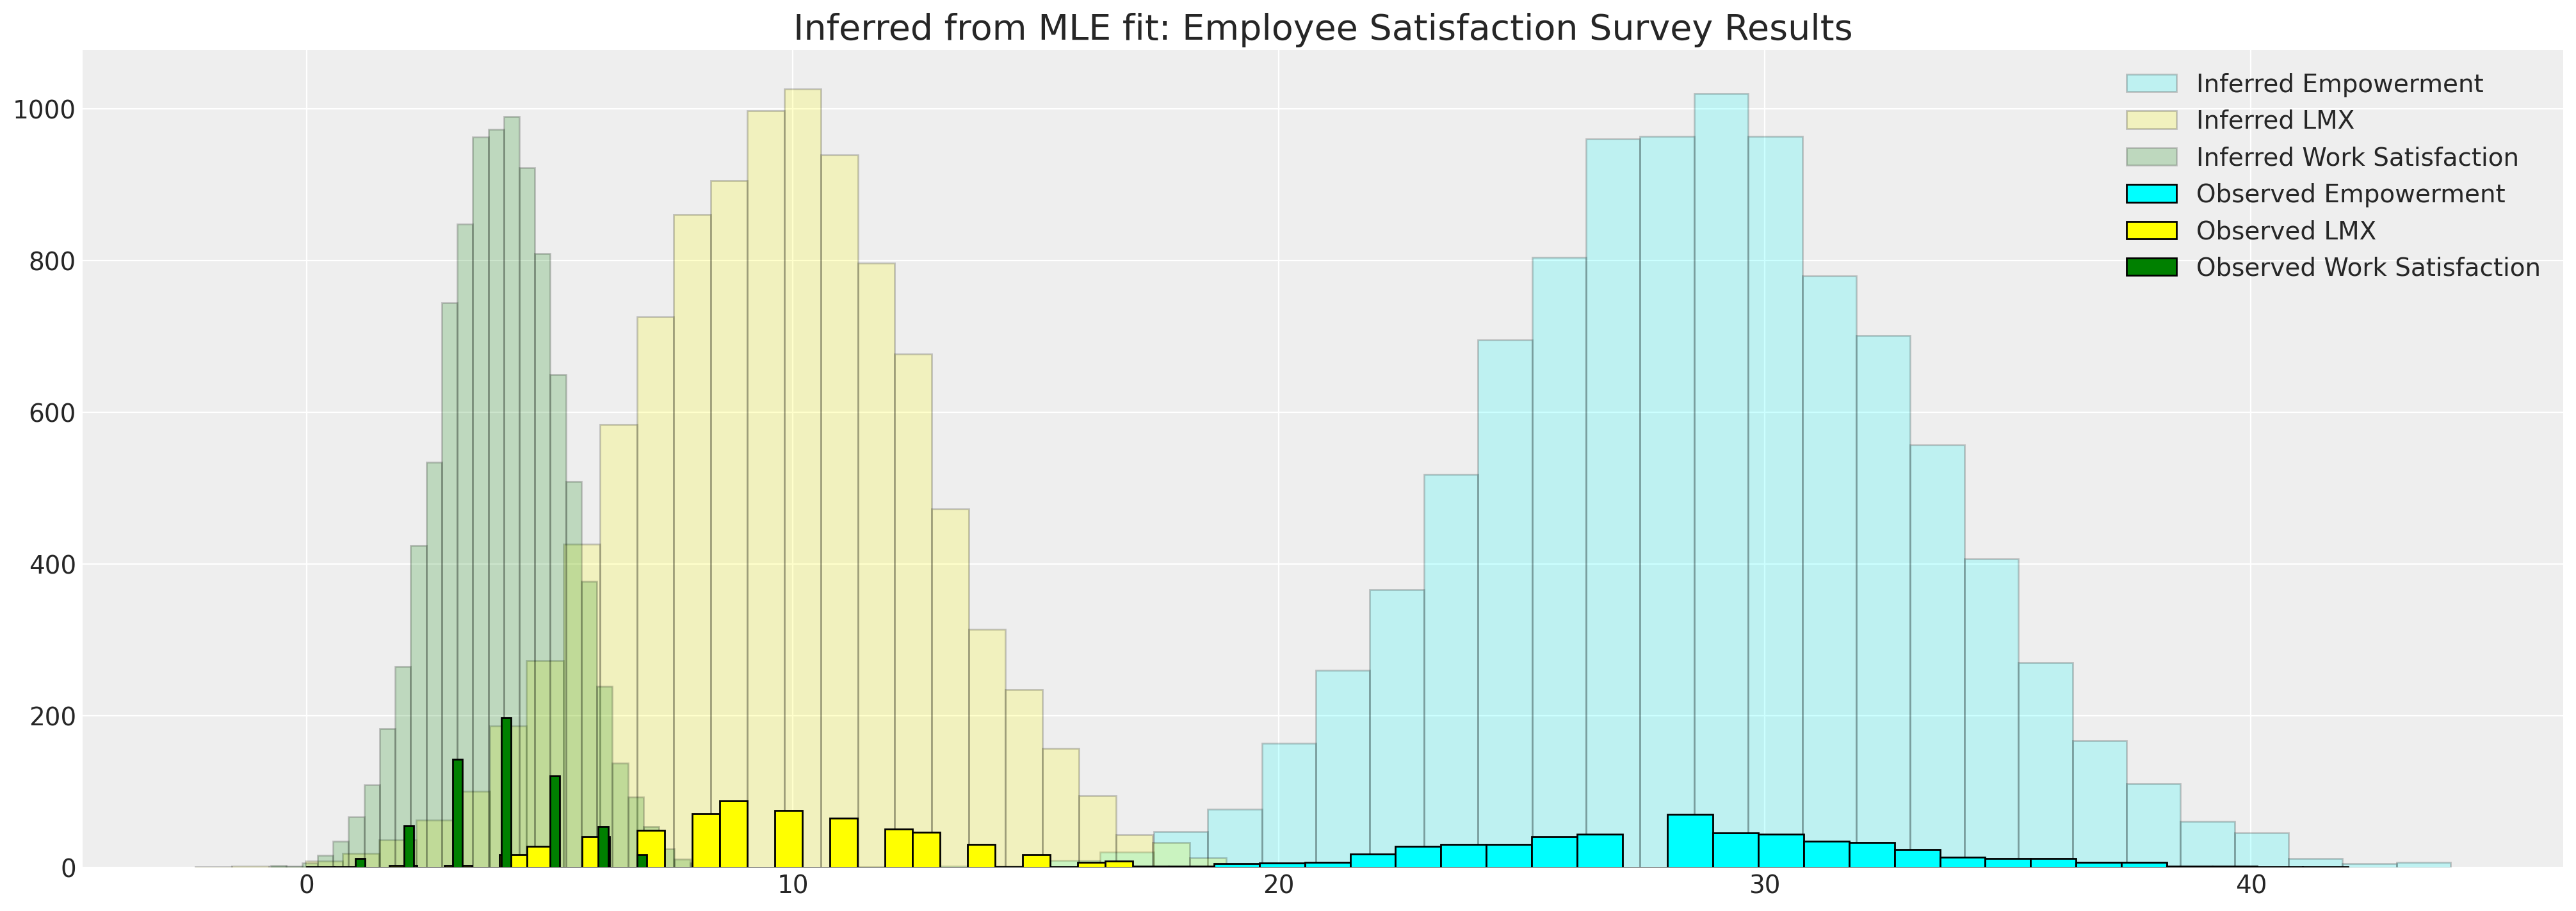

In [735]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(mle_sample['empower'], bins=30, ec='black', color='cyan', alpha=0.2, label='Inferred Empowerment')
ax.hist(mle_sample['lmx'], bins=30, ec='black', color='yellow', alpha=0.2, label='Inferred LMX')
ax.hist(mle_sample['worksat'], bins=30, ec='black', color='green', alpha=0.2, label='Inferred Work Satisfaction')
ax.hist(data['empower'], bins=30, ec='black', color='cyan', label='Observed Empowerment')
ax.hist(data['lmx'], bins=30, ec='black', color='yellow', label='Observed LMX')
ax.hist(data['worksat'], bins=30, ec='black', color='green', label='Observed Work Satisfaction')
ax.set_title("Inferred from MLE fit: Employee Satisfaction Survey Results", fontsize=20)
ax.legend()

### The Correlation Between the Imputed Metrics Data

In [730]:
pd.DataFrame(mle_sample.corr(), columns=data.columns, index=data.columns)

,worksat,empower,lmx
worksat,1.000000,0.299923,0.411317
empower,0.299923,1.000000,0.423779
lmx,0.411317,0.423779,1.000000


### Bootstrapping Sensitivity Analysis

In [829]:
data_200 = df_employee[['worksat', 'empower', 'lmx']].dropna().sample(200)
data_200.reset_index(inplace=True, drop=True)


sensitivity = {}
n_missing = np.linspace(30, 100, 5) ## Change or alter the range as desired
bootstrap_iterations = 100 #change to large number running a real analysis
for n in n_missing:
    sensitivity[int(n)] = {}
    sensitivity[int(n)]['mus'] = []
    sensitivity[int(n)]['cov'] = []
    for i in range(bootstrap_iterations):
        temp  = data_200.copy()
        for m in range(int(n)):
            i = random.choice(range(200))
            j = random.choice(range(3))
            temp.iloc[i, j] = np.nan
        try:
            fiml_mus, fiml_cov = estimate(temp)
            sensitivity[int(n)]['mus'].append(fiml_mus)
            sensitivity[int(n)]['cov'].append(fiml_cov)
        except Exception as e:
            next


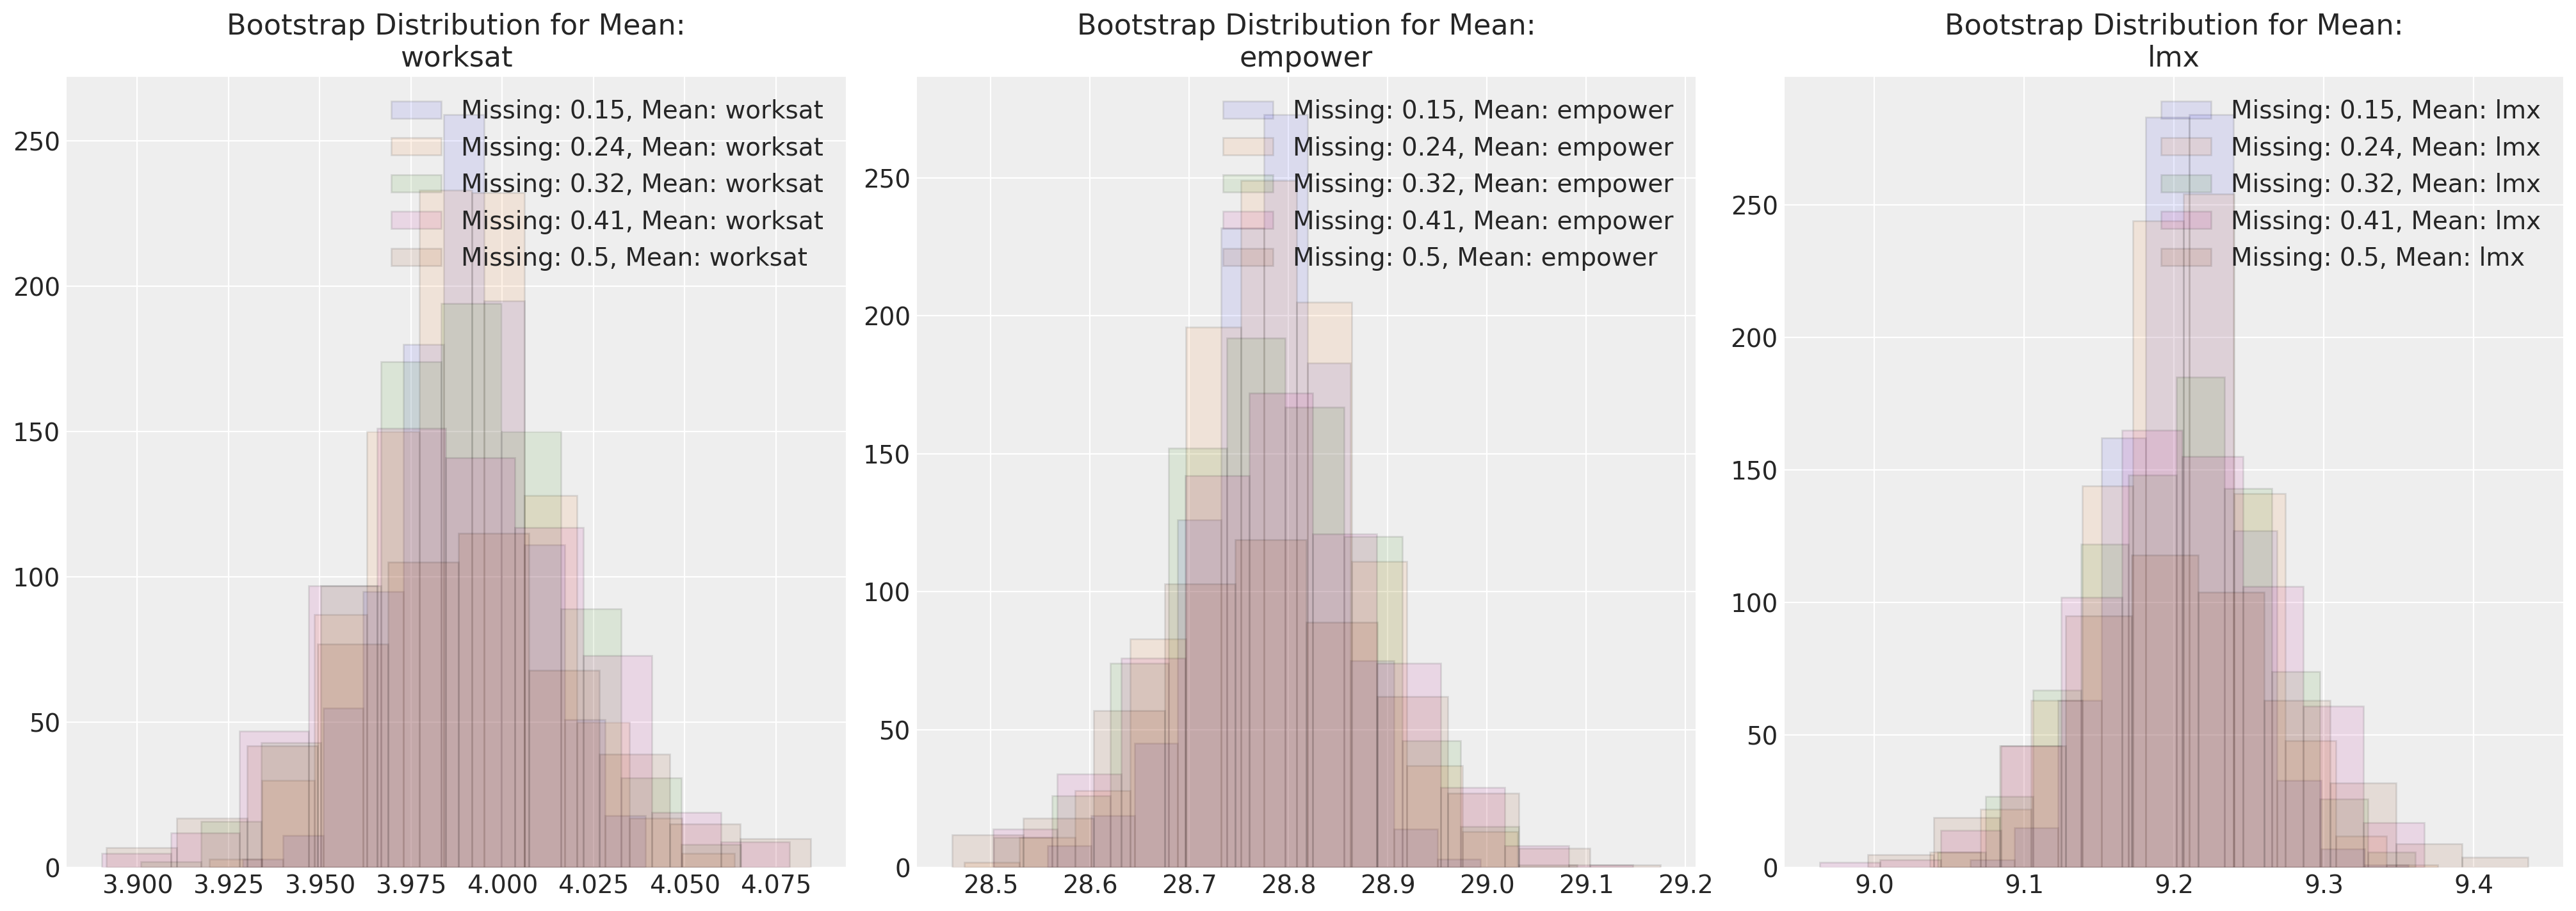

In [830]:
fig, axs = plt.subplots(1,3, figsize=(20, 7))
for n in sensitivity.keys():
    temp = pd.DataFrame(sensitivity[n]['mus'], columns=['worksat', 'empower', 'lmx'])
    for col, ax in zip(temp.columns, axs):
        ax.hist(temp[col], alpha=0.1, ec='black', label=f'Missing: {np.round(n/200, 2)}, Mean: {col}')
        ax.legend()
        ax.set_title(f'Bootstrap Distribution for Mean:\n{col}')

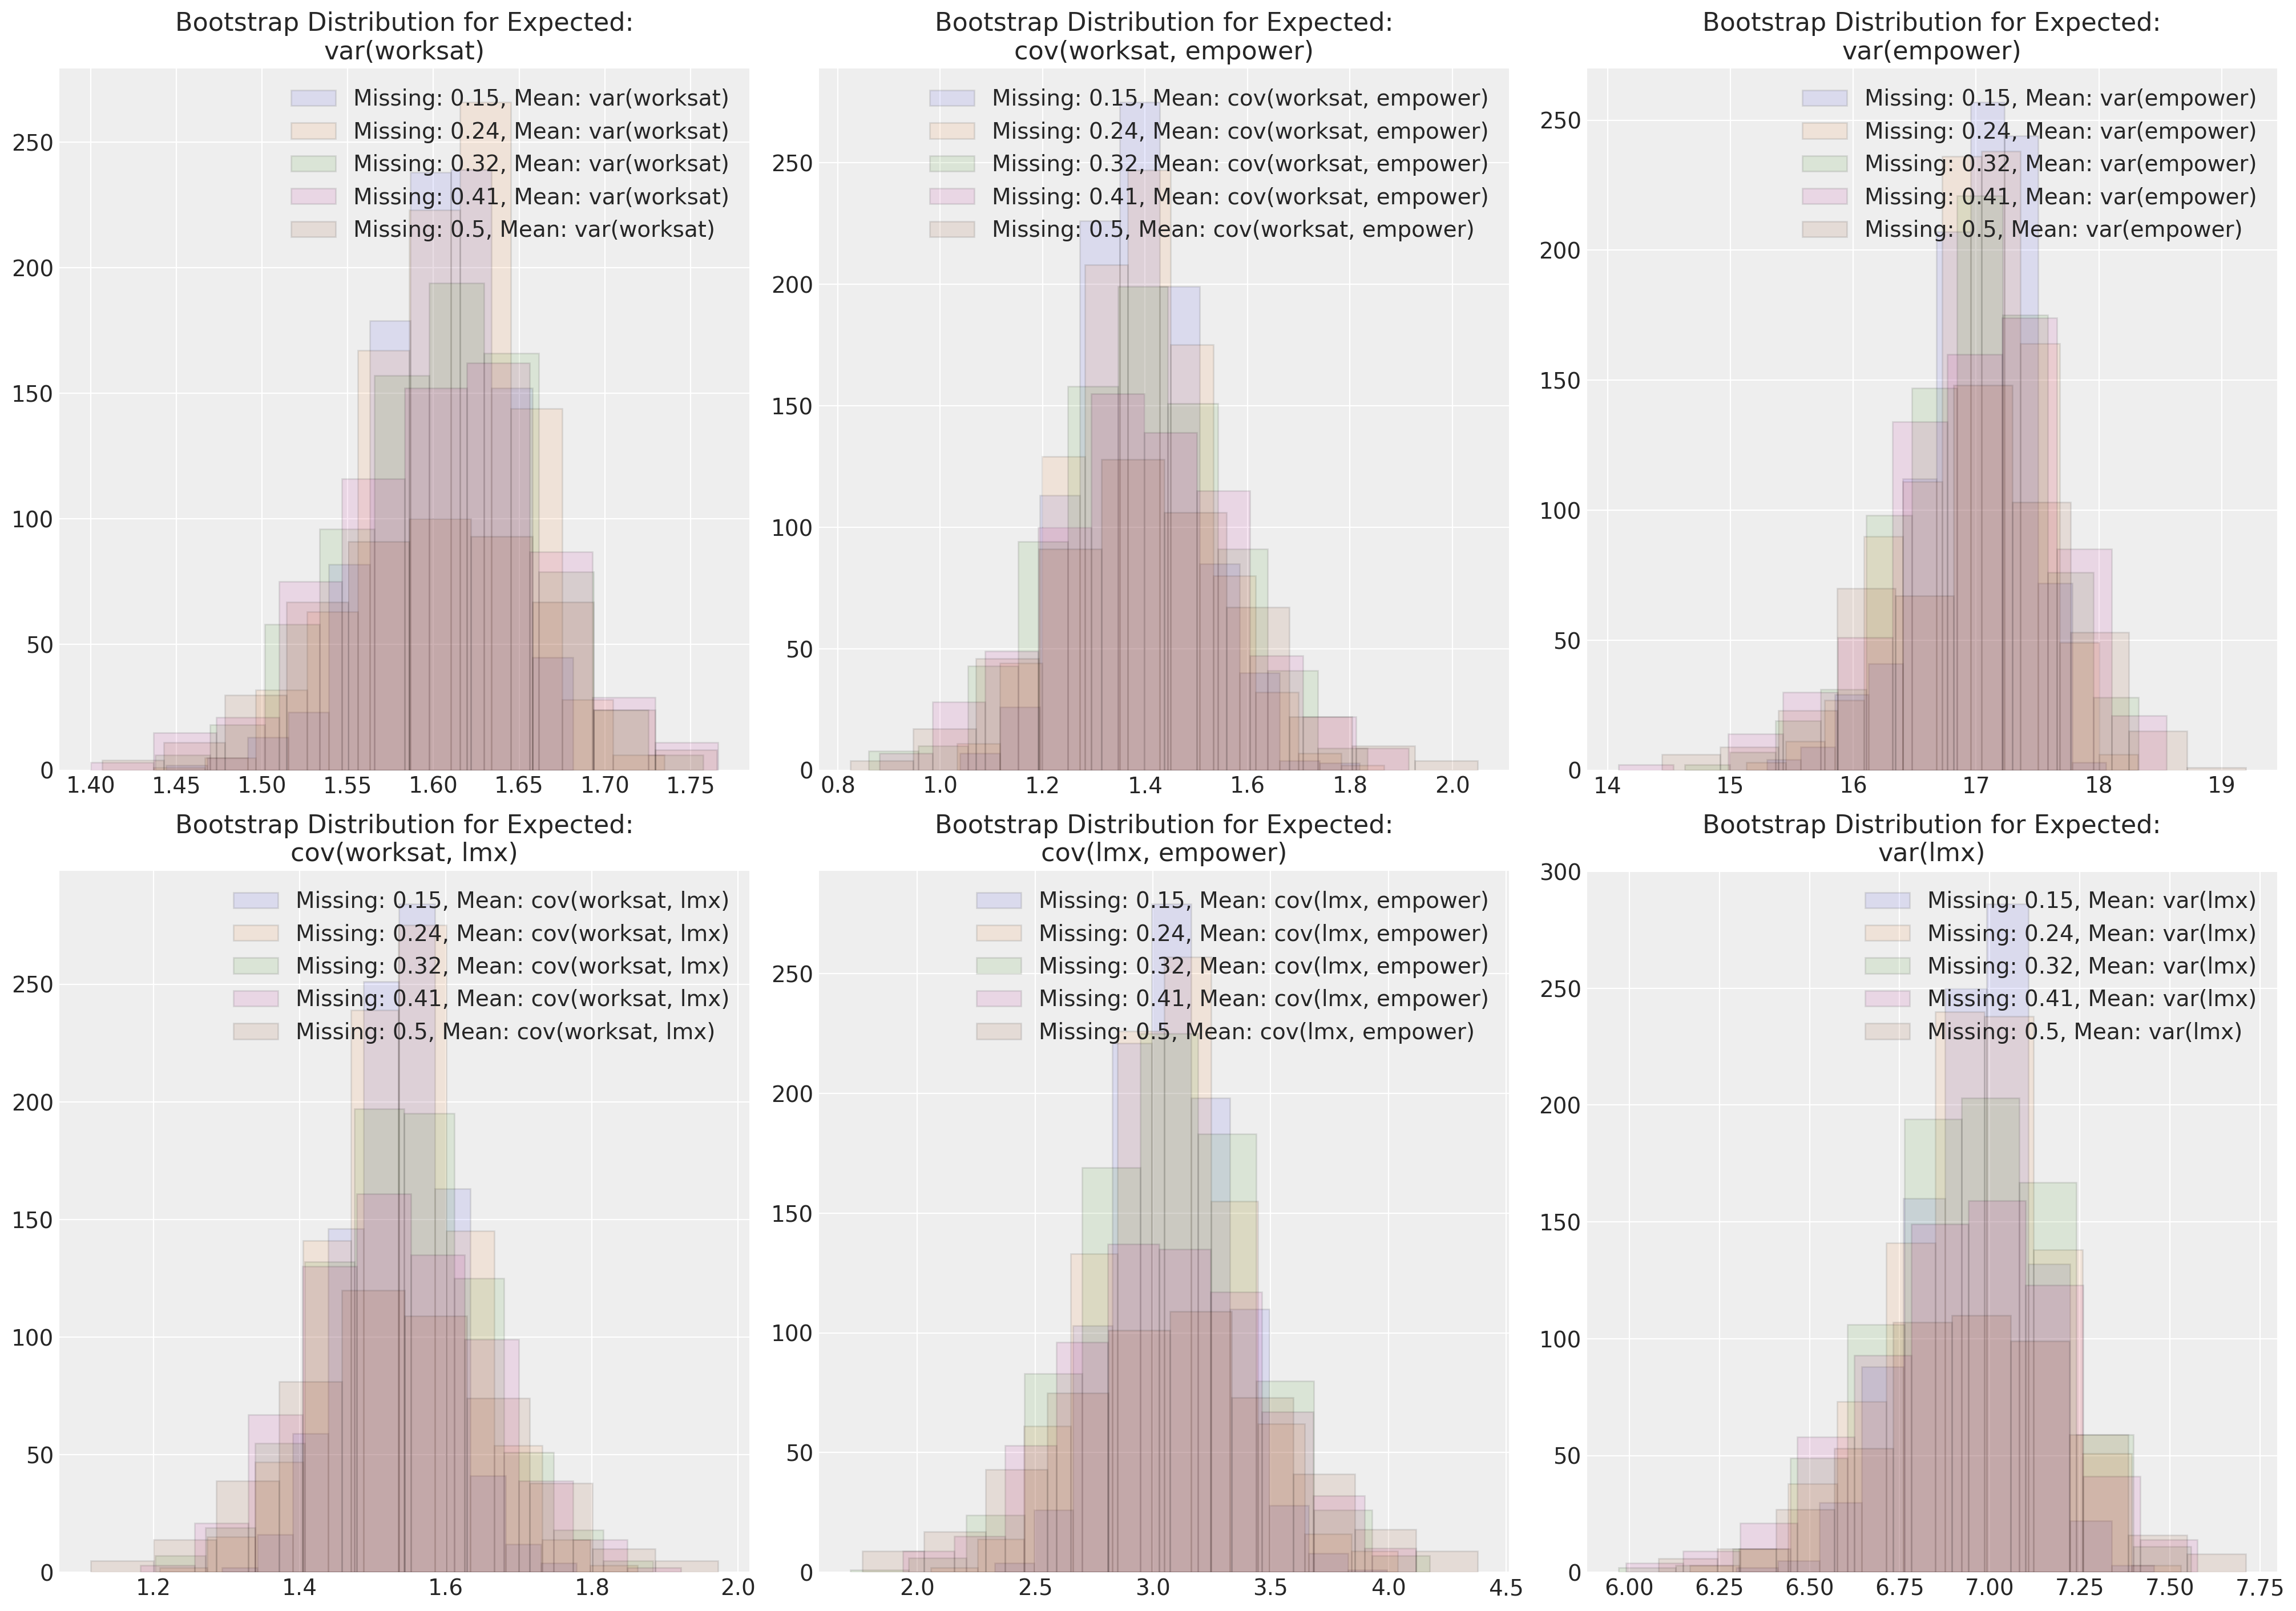

In [831]:
fig, axs = plt.subplots(2,3, figsize=(20, 14))
axs = axs.flatten()
for n in sensitivity.keys():
    length = len(sensitivity[n]['cov'])
    temp = pd.DataFrame([sensitivity[n]['cov'][i][np.tril_indices(3)] for i in range(length)], 
                        columns=['var(worksat)', 'cov(worksat, empower)', 'var(empower)', 'cov(worksat, lmx)',  'cov(lmx, empower)', 'var(lmx)'])
    for col, ax in zip(temp.columns, axs):
        ax.hist(temp[col], alpha=0.1, ec='black', label=f'Missing: {np.round(n/200, 2)}, Mean: {col}')
        ax.legend()
        ax.set_title(f'Bootstrap Distribution for Expected:\n{col}')

## Bayesian Imputation 

/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_10426/1311853708.py:18: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [cov, mus, x_unobs]
INFO:pymc:Sampling: [cov, mus, x_unobs]
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, cov, x_unobs]
INFO:pymc:NUTS: [mus, cov, x_unobs]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumP

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, cov, x_unobs]
INFO:pymc:NUTS: [mus, cov, x_unobs]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation f

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_10426/1311853708.py:21: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pm.sample_posterior_predictive(idata, extend_inferencedata=True)


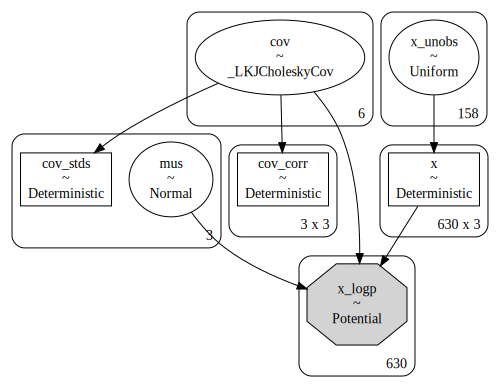

In [887]:
import pytensor.tensor as pt

with pm.Model() as model:
        # Priors
        mus = pm.Normal('mus', 0, 1, size=3)
        cov_flat_prior, _, _ = pm.LKJCholeskyCov(
            "cov", n=3, eta=1.0, sd_dist=pm.Exponential.dist(1)
        )
        # Create a vector of flat variables for the unobserved components of the MvNormal
        x_unobs = pm.Uniform("x_unobs",0, 100, shape=(np.isnan(data.values).sum(),))

        # Create the symbolic value of x, combining observed data and unobserved variables
        x = pt.as_tensor(data.values)
        x = pm.Deterministic("x", pt.set_subtensor(x[np.isnan(data.values)], x_unobs))

        # Add a Potential with the logp of the variable conditioned on `x`
        pm.Potential("x_logp", pm.logp(rv=pm.MvNormal.dist(mus, chol=cov_flat_prior), value=x))
        idata = pm.sample_prior_predictive()
        idata = pm.sample()
        idata.extend(pm.sample(random_seed=120))
        pm.sample_posterior_predictive(idata, extend_inferencedata=True)

pm.model_to_graphviz(model)


In [911]:
az.summary(idata, var_names=['mus', 'cov','x_unobs'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mus[0],3.871,0.052,3.773,3.971,0.001,0.000,5538.0,3330.0,1.0
mus[1],27.473,0.193,27.125,27.839,0.002,0.002,6029.0,2939.0,1.0
mus[2],9.228,0.123,8.984,9.445,0.002,0.001,6183.0,3428.0,1.0
cov[0],1.272,0.037,1.203,1.341,0.000,0.000,5682.0,3514.0,1.0
cov[1],1.350,0.207,0.940,1.722,0.003,0.002,5841.0,3234.0,1.0
...,...,...,...,...,...,...,...,...,...
x_unobs[153],29.871,4.167,21.797,37.454,0.050,0.035,7084.0,2416.0,1.0
x_unobs[154],2.544,1.104,0.352,4.454,0.019,0.013,3018.0,1609.0,1.0
x_unobs[155],29.982,4.007,22.686,37.851,0.046,0.033,7410.0,3005.0,1.0
x_unobs[156],29.572,4.012,21.609,36.613,0.044,0.031,8195.0,3202.0,1.0


In [912]:
imputed_dims = data.shape
imputed = data.values.flatten()
imputed[np.isnan(imputed)] = az.summary(idata, var_names=['x_unobs'])['mean'].values
imputed = imputed.reshape(imputed_dims[0], imputed_dims[1])
imputed = pd.DataFrame(imputed, columns = [col + '_imputed' for col in data.columns])
imputed.head(10)



,worksat_imputed,empower_imputed,lmx_imputed
0,3.000,32.000,11.000
1,4.000,29.407,13.000
2,4.000,30.000,9.000
3,3.000,29.000,8.000
4,4.000,26.000,7.000
5,4.022,27.936,10.000
6,5.000,28.960,11.000
7,3.000,22.000,9.000
8,2.000,23.000,6.787
9,4.000,32.000,9.000


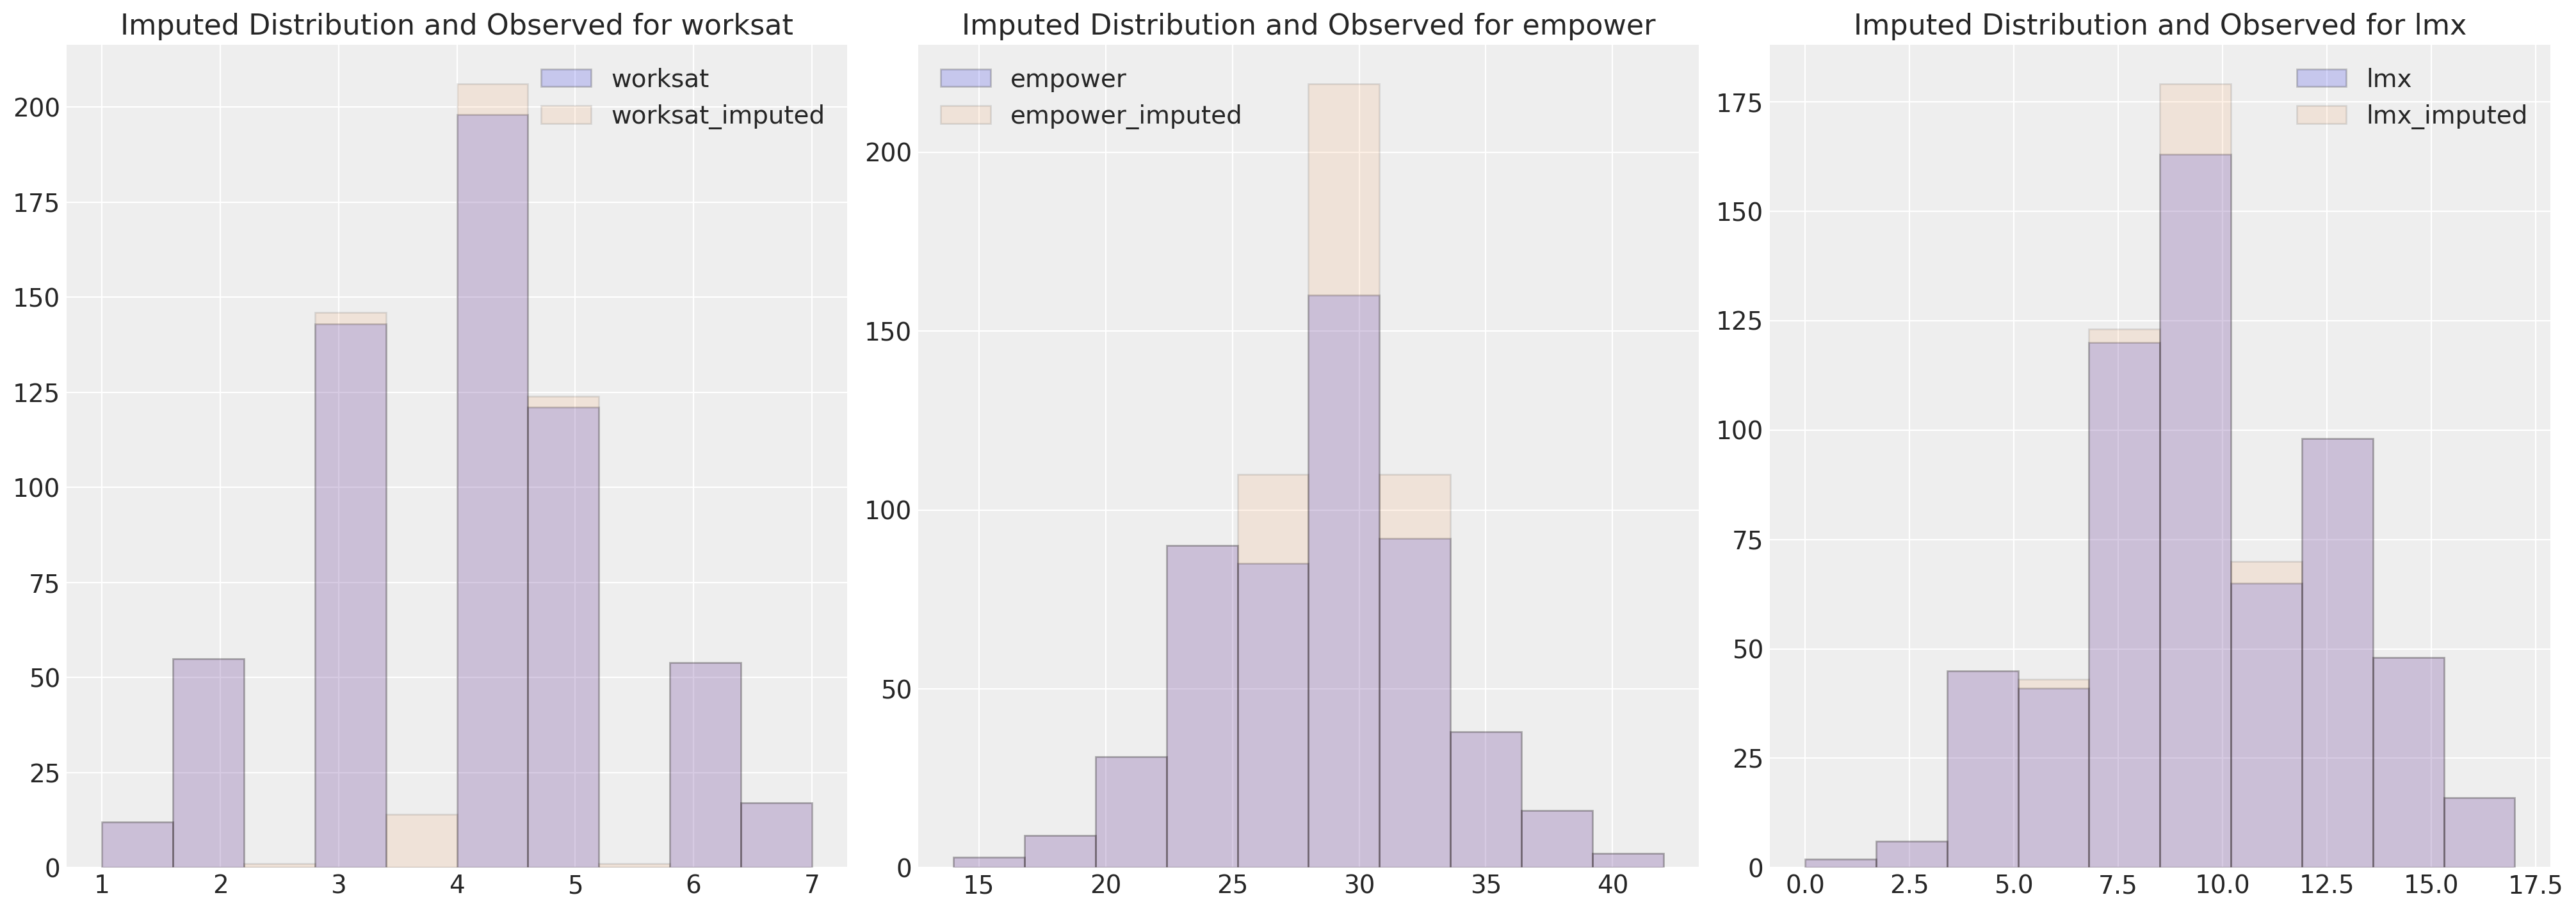

In [913]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs = axs.flatten()
for col, col_i, ax in zip(data.columns, imputed.columns, axs):
    ax.hist(data[col], label=col, alpha=0.2, ec='black')
    ax.hist(imputed[col_i], label=col_i, alpha=0.1, ec='black')
    ax.legend()
    ax.set_title(f'Imputed Distribution and Observed for {col}')


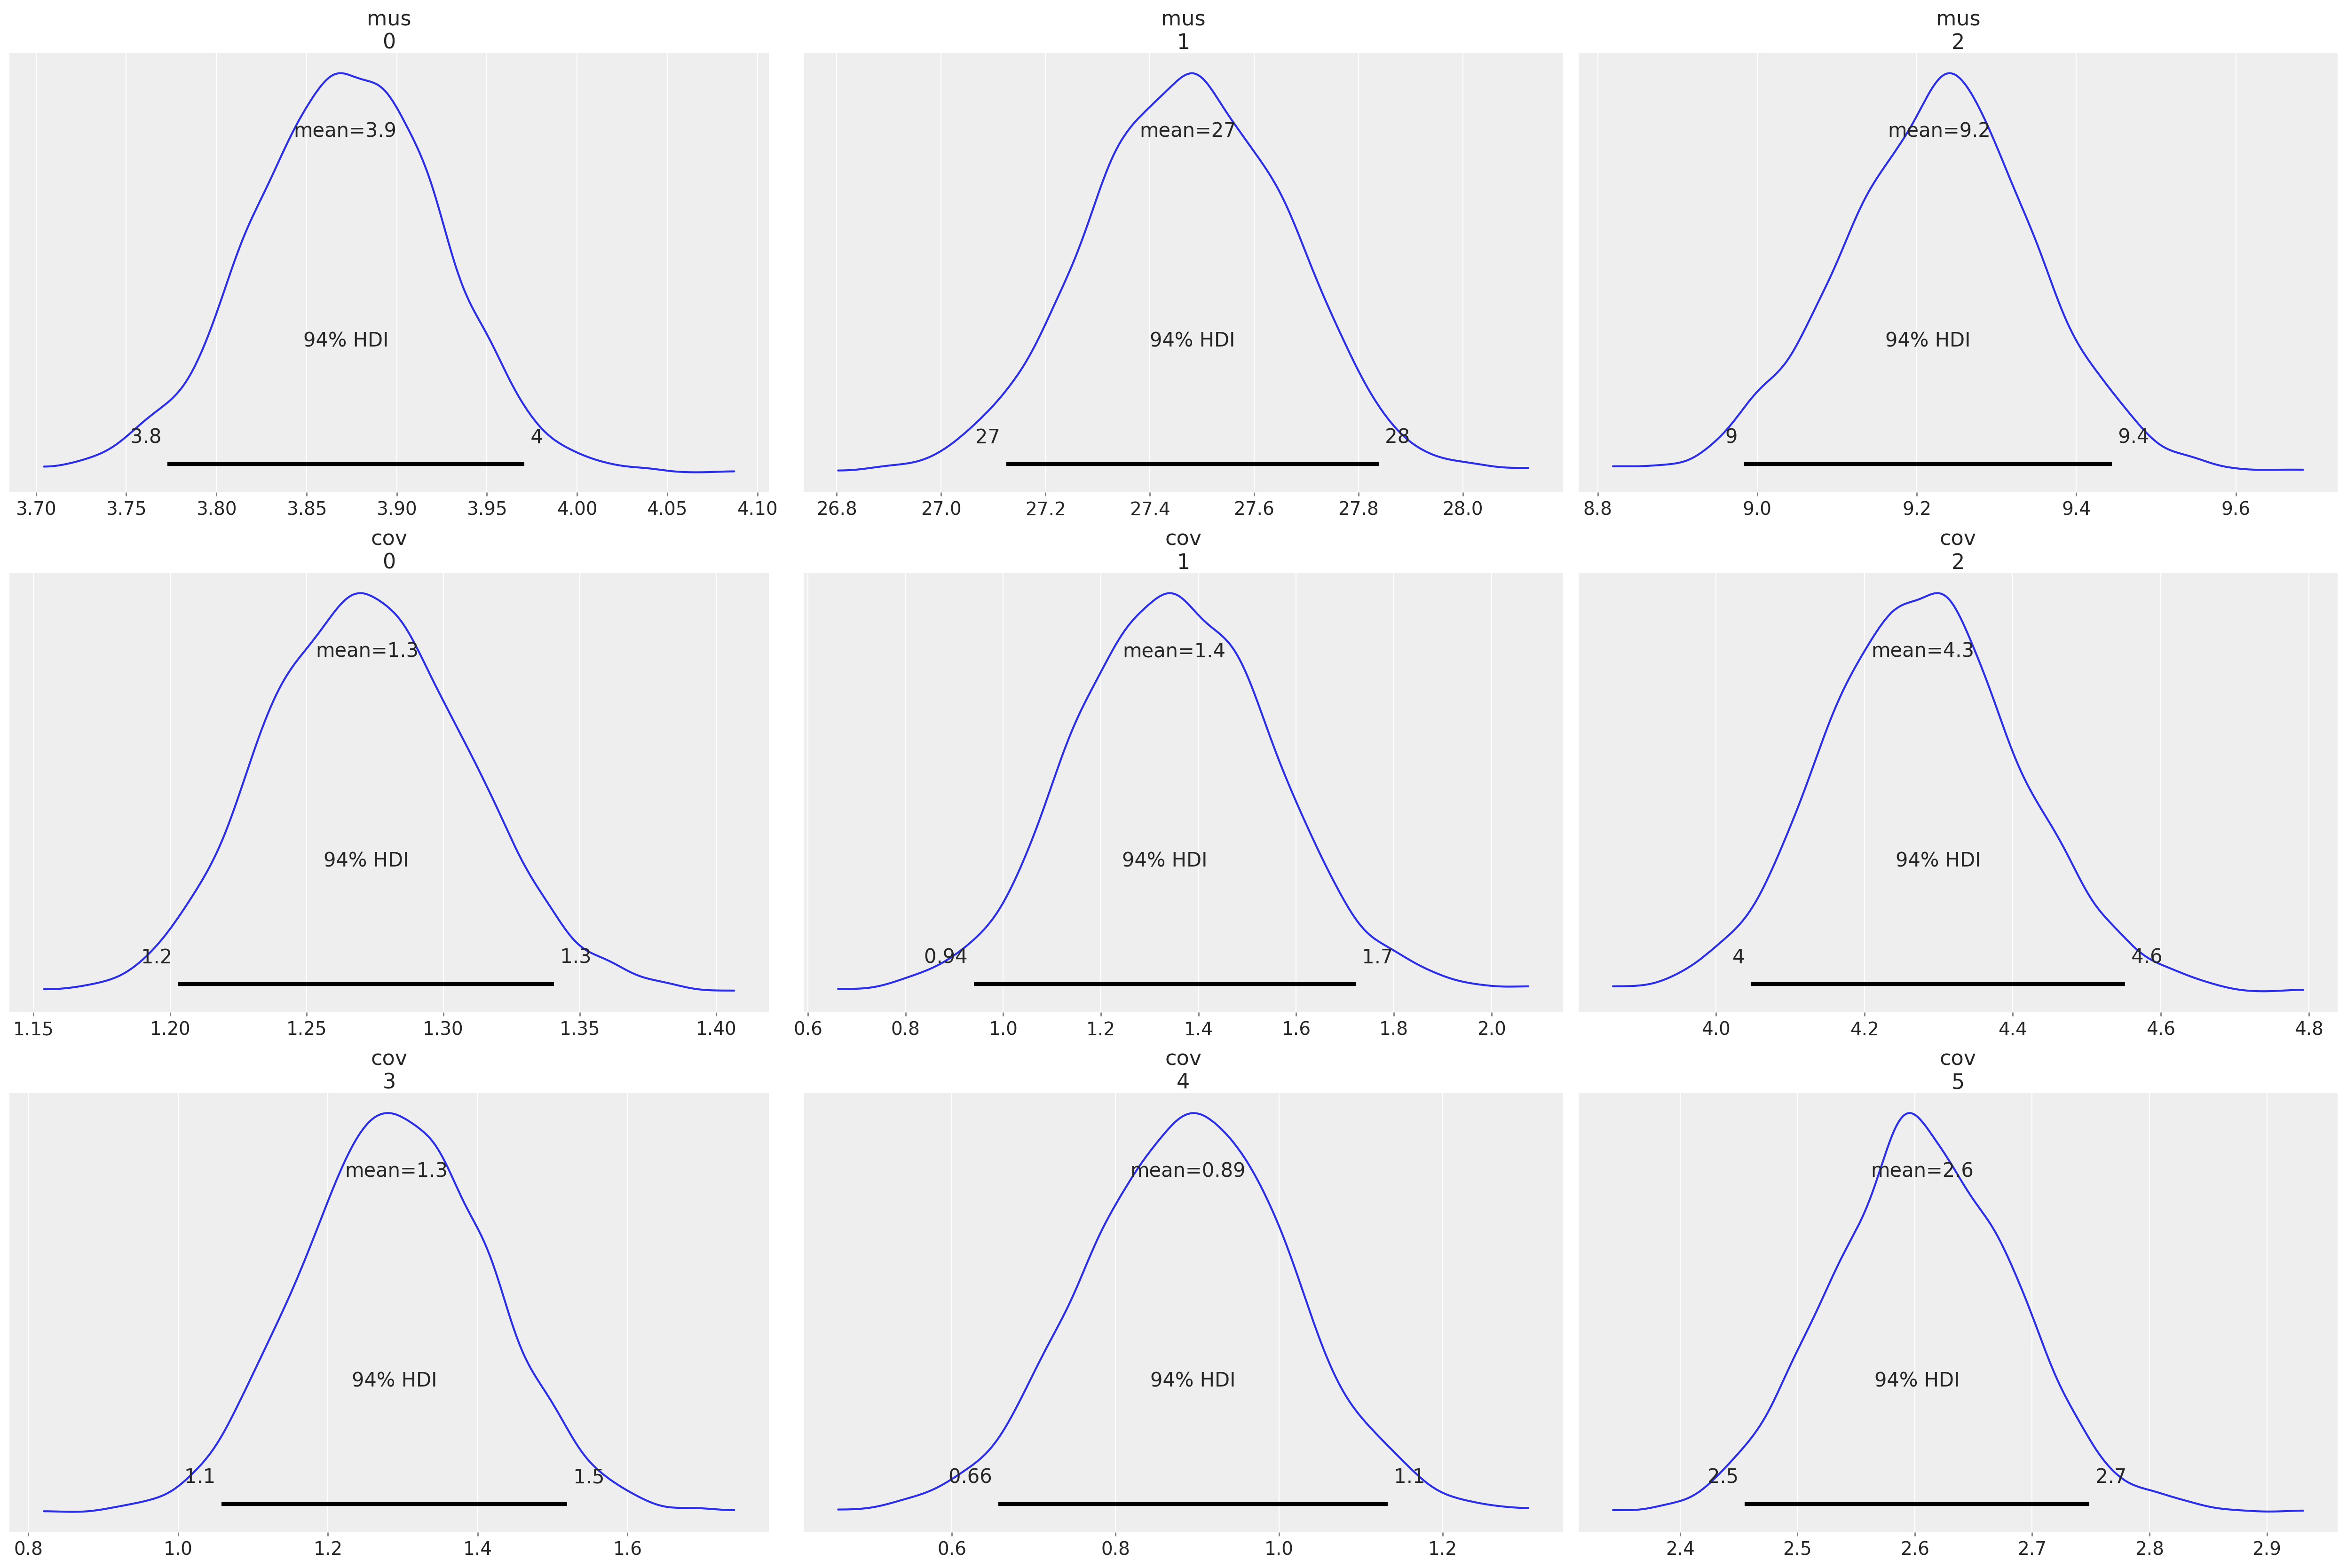

In [914]:
az.plot_posterior(idata, var_names=['mus', 'cov']);

In [915]:
pd.DataFrame(az.summary(idata, var_names=['cov_corr'])['mean'].values.reshape(3, 3))

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,0,1,2
0,1.000,0.300,0.424
1,0.300,1.000,0.406
2,0.424,0.406,1.000


## Authors
- Authored by [Nathaniel Forde](..) in January 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark


In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Jan 12 2023

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.4.0

pytensor: 2.8.11

pandas    : 1.5.1
pymc      : 5.0.1
numpy     : 1.23.4
sys       : 3.9.0 (default, Nov 15 2020, 06:25:35) 
[Clang 10.0.0 ]
matplotlib: 3.6.1
arviz     : 0.14.0

Watermark: 2.3.1

